In [95]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from math import sqrt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Project 2 Task 5

In [2]:
data = pd.read_excel("18EA1-5 database cleaned HO only-version2.xlsx")

### Data Analysis

In [3]:
data.head(5)

,Cow,Farm,System,Parity,ParityCategory,BCS,DIM,DIC,Pregnant,FatPEBV,...,"10,12/preformed",20:2n6/preformed,22/preformed,20:3n6/preformed,20:4n6/preformed,20:5n3/preformed,MFD,(C13 - C11)/OBC,(C14 - C12)/DN,Trans as % of preformed
0,43,1,CM,5,3plus,3.250,200.0,0,N,-0.200,...,0.00000,0.000726,0.000663,0.004169,0.003576,0.000746,No,0.017162,0.305421,0.075902
1,51,1,CM,5,3plus,2.750,72.0,0,U,0.070,...,0.00162,0.000000,0.000624,0.001575,0.002038,0.000000,Yes,0.022726,0.281875,0.197800
2,405,1,CM,5,3plus,NaN,212.0,0,N,NaN,...,0.00000,0.001104,0.001000,0.003100,0.004451,0.000705,No,0.010826,0.240153,0.084820
3,408,1,CM,4,3plus,2.750,211.0,0,U,-0.070,...,0.00000,0.001005,0.000442,0.002461,0.004562,0.000727,Yes,0.013623,0.296892,0.105783
4,423,1,CM,5,3plus,2.875,228.0,0,N,-0.215,...,0.00000,0.000849,0.000583,0.003857,0.003656,0.000480,Yes,0.011611,0.297311,0.098821


#### Null values in Dataset

In [4]:
null_summary = data.isnull().sum().sort_values(ascending=False)

In [5]:
"""for i, j in zip(null_summary.index, null_summary.values):
    print("Column: %s" % i)
    print("\tNull Count: %d\n" % j)"""

'for i, j in zip(null_summary.index, null_summary.values):\n    print("Column: %s" % i)\n    print("\tNull Count: %d\n" % j)'

C20:2n6 and BCS have too many null values. These are features that seem like they would be important in determining our target values. Imputing for these instances would not be smart, as it could have negative effects on our model. We will choose to remove these two features instead, in order to preserve more data. 

### Data Preprocessing

In [6]:
# get only numerical features
filtered_data = data.select_dtypes(include="float")

In [7]:
numerical_features = filtered_data.columns
categorical_features = data.columns.difference(filtered_data.columns)
targets = ["AvgMilk", "Fat%", "FatY", "Pro%", "ProY"]
null_columns = list(null_summary.index[:12])

In [8]:
# drop target and features with too many nulls, then drop rows with null values
X = filtered_data.drop(targets + null_columns, axis=1).dropna()

# subset y with rows of X, and drop target rows with null values
y = data.loc[X.index, targets].dropna()

# subset X for only available rows of y
X = X.loc[y.index, :]

# normalize feature vectors
X = X.apply(lambda x: (x - x.mean()) / x.std())

# Task 6

We will first add the categorical variables and retrain our models accordingly

In [56]:
null_summary = data.isnull().sum().sort_values(ascending=False)

targets = ["AvgMilk", "Fat%", "FatY", "Pro%", "ProY"]
questionable_features = ["ECM", "0.4 FCM", "SCCS"]
null_columns = list(null_summary.index[:12])


filtered_data = data.select_dtypes(include="float")
numerical_features = filtered_data.columns
categorical_features = data.columns.difference(filtered_data.columns)

# drop targets, questionable_features, and features with too many nulls, then drop rows with null values
X = data.drop(targets + null_columns + questionable_features, axis=1).dropna()

print(X.head())


   Cow  Farm System  Parity ParityCategory    DIM  DIC Pregnant     DN  \
0   43     1     CM       5          3plus  200.0    0        N  24.75   
1   51     1     CM       5          3plus   72.0    0        U  21.13   
2  405     1     CM       5          3plus  212.0    0        N  22.20   
3  408     1     CM       4          3plus  211.0    0        U  24.74   
4  423     1     CM       5          3plus  228.0    0        N  23.12   

        OBC           ...             10,12/preformed  20:2n6/preformed  \
0  2.733981           ...                     0.00000          0.000726   
1  3.295293           ...                     0.00162          0.000000   
2  3.700177           ...                     0.00000          0.001104   
3  4.272894           ...                     0.00000          0.001005   
4  3.329128           ...                     0.00000          0.000849   

   22/preformed  20:3n6/preformed  20:4n6/preformed  20:5n3/preformed  MFD  \
0      0.000663          0

In [57]:
categorical_features = categorical_features.drop(["Cow","Parity","DIC"])
for cat in categorical_features:
    print(X[cat].value_counts())


1    498
2    415
4    294
5    206
3    171
Name: Farm, dtype: int64
No     1200
Yes     384
Name: MFD, dtype: int64
3plus    571
1        539
2        474
Name: ParityCategory, dtype: int64
P    849
U    578
N    157
Name: Pregnant, dtype: int64
CM     875
SCR    709
Name: System, dtype: int64


In [58]:
#Replace categorical features with dummy columns
for cat in categorical_features:
    dummies = pd.get_dummies(X[cat]).rename(columns=lambda x: cat + '_' + str(x))
    X = pd.concat([X, dummies], axis=1)
    X = X.drop([cat], axis=1)

In [59]:
X = X.drop(["Parity","Cow"],axis=1)
print(X.head())

     DIM  DIC     DN       OBC    16C    18C  18Cplus   DNyield  OBCyield  \
0  200.0    0  24.75  2.733981  33.94  35.44    35.95  0.329942  0.036447   
1   72.0    0  21.13  3.295293  28.87  44.72    45.09  0.237866  0.037096   
2  212.0    0  22.20  3.700177  27.66  44.43    45.16  0.176629  0.029440   
3  211.0    0  24.74  4.272894  36.65  32.40    32.85  0.338185  0.058409   
4  228.0    0  23.12  3.329128  32.65  39.15    39.72  0.292557  0.042126   

   16Cyield     ...      MFD_No  MFD_Yes  ParityCategory_1  ParityCategory_2  \
0  0.452454     ...           1        0                 0                 0   
1  0.324998     ...           0        1                 0                 0   
2  0.220071     ...           1        0                 0                 0   
3  0.500989     ...           0        1                 0                 0   
4  0.413149     ...           0        1                 0                 0   

   ParityCategory_3plus  Pregnant_N  Pregnant_P  Pregnan

In [60]:
# subset y with rows of X, and drop target rows with null values
y = data.loc[X.index, targets].dropna()

# subset X for only available rows of y
X = X.loc[y.index, :]

num_feat = numerical_features.difference(targets)
num_feat = num_feat.difference(questionable_features)
num_feat = num_feat.difference(null_columns)
# normalize feature vectors only over numerical features
X[np.array(num_feat)] = X[num_feat].apply(lambda x: (x - x.mean()) / x.std())

X = X.reset_index()


In [62]:
X.head()

,index,DIM,DIC,DN,OBC,16C,18C,18Cplus,DNyield,OBCyield,...,MFD_No,MFD_Yes,ParityCategory_1,ParityCategory_2,ParityCategory_3plus,Pregnant_N,Pregnant_P,Pregnant_U,System_CM,System_SCR
0,0,0.258965,0,-0.574733,-1.626048,0.098354,0.464811,0.457575,-0.238975,-0.704960,...,1,0,0,0,1,1,0,0,1,0
1,1,-1.094116,0,-1.513597,-0.462016,-1.327251,2.358164,2.322890,-1.001870,-0.657863,...,0,1,0,0,1,0,0,1,1,0
2,2,0.385816,0,-1.236087,0.377621,-1.667484,2.298997,2.337176,-1.509252,-1.213171,...,1,0,0,0,1,1,0,0,1,0
3,3,0.375245,0,-0.577326,1.565306,0.860363,-0.155425,-0.175081,-0.170679,0.887901,...,0,1,0,0,1,0,0,1,1,0
4,4,0.554951,0,-0.997481,-0.391849,-0.264374,1.221744,1.226967,-0.548727,-0.293024,...,0,1,0,0,1,1,0,0,1,0


## Training Models with Categorical Variables

In [63]:
lasso_target_scores_cat = {}
rf_target_scores_cat = {}
targets = ["AvgMilk", "Fat%", "FatY", "Pro%", "ProY"]
for target in targets:
    X_train, X_test, y_train, y_test = train_test_split(X, y[target],test_size=.2)

    lasso = Lasso(alpha=0)
    lasso.fit(X_train, y_train)
    lasso_target_scores_cat[target] = lasso.score(X_test, y_test)
    
for target in targets:
    X_train, X_test, y_train, y_test = train_test_split(X, y[target],test_size=.2)
    
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_target_scores_cat[target] = rf.score(X_test, y_test)
    



    

In [64]:
print("Lasso with Categorical Features")
print(lasso_target_scores_cat, end="\n\n")
print("Random Forest with Categorical Features")
print(rf_target_scores_cat, end="\n\n")


Lasso with Categorical Features
{'AvgMilk': 0.8209005668897862, 'Fat%': 0.7746721396135329, 'FatY': 0.9994410517478457, 'Pro%': 0.5579119506315211, 'ProY': 0.7524597625952422}

Random Forest with Categorical Features
{'AvgMilk': 0.7964460827360527, 'Fat%': 0.6135951616977064, 'FatY': 0.9904091121765356, 'Pro%': 0.4528934273816213, 'ProY': 0.7653219310793218}



## PCA

We decided to apply PCA on solely the fatty acids, since those should be highly correlated

In [65]:
usable = ["DIM","DIC","AvgRum","Farm_1","Farm_2","Farm_3","Farm_4","Farm_5","MFD_No","MFD_Yes","ParityCategory_1","ParityCategory_2","ParityCategory_3plus","Pregnant_N","Pregnant_P","Pregnant_U","System_CM","System_SCR"]
X_usable = X[usable]
X_needs_PCA = X.drop(usable,axis=1)
X_usable = X_usable.reset_index()

In [66]:
pca = PCA(n_components=70)
pca.fit(X_needs_PCA, y["AvgMilk"])
new_X = pd.DataFrame(pca.transform(X_needs_PCA))
print(new_X.shape)
print(X_usable.shape)

(1575, 70)
(1575, 19)


In [67]:
X_with_PCA = pd.concat([X_usable,new_X],axis=1)
X_with_PCA = X_usable.join(new_X)

## Training Models with PCA

In [68]:
lasso_target_scores_pca = {}
rf_target_scores_pca = {}
targets = ["AvgMilk", "Fat%", "FatY", "Pro%", "ProY"]
for target in targets:
    X_train, X_test, y_train, y_test = train_test_split(X_with_PCA, y[target],test_size=.2)

    lasso = Lasso(alpha=0)
    lasso.fit(X_train, y_train)
    lasso_target_scores_pca[target] = lasso.score(X_test, y_test)
    
for target in targets:
    X_train, X_test, y_train, y_test = train_test_split(X_with_PCA, y[target],test_size=.2)
    
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_target_scores_pca[target] = rf.score(X_test, y_test)
    


In [71]:
print("Lasso with PCA")
print(lasso_target_scores_pca, end="\n\n")
print("Random Forest with PCA")
print(rf_target_scores_pca, end="\n\n")

Lasso with PCA
{'AvgMilk': 0.8541216541575705, 'Fat%': 0.7183945075474053, 'FatY': 0.9999419488329013, 'Pro%': 0.5479918285267509, 'ProY': 0.773752856858163}

Random Forest with PCA
{'AvgMilk': 0.6707682650754663, 'Fat%': 0.6115574476399805, 'FatY': 0.7664184566241786, 'Pro%': 0.4354409576103545, 'ProY': 0.6077040334434027}



As we can see, adding PCA to our new models hasn't improved anything, but we suspect that after we optimize our hyper-parameters next week(picking a better value for n_components, for example) our results will improve

## 10-Fold Cross Validation

In [72]:
lasso_scores_PCA = {}
lasso_scores_no_PCA = {}
rf_scores_PCA = {}
rf_scores_no_PCA = {}
for target in targets:
    lasso = Lasso(alpha=0)
    rf = RandomForestRegressor(n_estimators=100)
    lasso_scores_PCA[target] = np.mean(cross_val_score(lasso, X_with_PCA, y[target], cv=10))
    lasso_scores_no_PCA[target] = np.mean(cross_val_score(lasso,X,y[target],cv=10))
    rf_scores_PCA[target] = np.mean(cross_val_score(rf,X_with_PCA,y[target],cv=10))
    rf_scores_no_PCA[target] = np.mean(cross_val_score(rf,X,y[target],cv=10))

print("Lasso with PCA CV")
print(lasso_scores_PCA,end="\n\n")
print("Lasso without PCA CV")
print(lasso_scores_no_PCA,end="\n\n")
print("RF wth PCA CV")
print(rf_scores_PCA,end="\n\n")
print("RF without PCA CV")
print(rf_scores_no_PCA,end="\n\n")

Lasso with PCA CV
{'AvgMilk': 0.7655683201163681, 'Fat%': 0.6436023994882477, 'FatY': 0.9998117961273358, 'Pro%': 0.48877503241347287, 'ProY': 0.6824010710329282}

Lasso without PCA CV
{'AvgMilk': 0.7679466970287441, 'Fat%': 0.640794470783614, 'FatY': 0.999864601653468, 'Pro%': 0.4859129114398847, 'ProY': 0.6810351281162589}

RF wth PCA CV
{'AvgMilk': 0.5516992048219314, 'Fat%': 0.44121283697032804, 'FatY': 0.6547909662209255, 'Pro%': 0.4194356929987718, 'ProY': 0.46586353167417516}

RF without PCA CV
{'AvgMilk': 0.6633804266940679, 'Fat%': 0.5320156810595665, 'FatY': 0.9871844332096028, 'Pro%': 0.4261516701534066, 'ProY': 0.6557983263204326}



# Evaluation Metrics

In [84]:
lasso_pca_target_scores = {}
lasso_pca_target_rmse = {}
lasso_pca_target_adjr2 = {}
lasso_target_scores = {}
lasso_target_rmse = {}
lasso_target_adjr2 = {}
rf_pca_target_scores = {}
rf_pca_target_rmse = {}
rf_pca_target_adjr2 = {}
rf_target_scores = {}
rf_target_rmse = {}
rf_target_adjr2 = {}

lasso_pca_preds = {}
lasso_preds = {}
rf_pca_preds = {}
rf_preds= {}

target_pca_splits = {}
target_splits = {}

d = X.shape[1]

In [85]:
for target in targets:
    target_splits[target] = train_test_split(X, y[target],test_size=.3)
    target_pca_splits[target] = train_test_split(new_X, y[target],test_size=.3)

## Lasso with PCA

In [86]:
# lasso with PCA
for target in targets:
    X_train, X_test, y_train, y_test = target_pca_splits[target]

    lasso = Lasso(alpha=0)
    lasso.fit(X_train, y_train)
    lasso_pca_target_scores[target] = lasso.score(X_test, y_test)
    lasso_pca_preds[target] = lasso.predict(X_test)
    lasso_pca_target_adjr2[target] = (1 - (1 - lasso_pca_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    lasso_pca_target_rmse[target] = sqrt(mean_squared_error(y_test, lasso_pca_preds[target]))

## Lasso Without PCA

In [87]:
for target in targets:
    X_train, X_test, y_train, y_test = target_splits[target]

    lasso = Lasso(alpha=0)
    lasso.fit(X_train, y_train)
    lasso_target_scores[target] = lasso.score(X_test, y_test)
    lasso_preds[target] = lasso.predict(X_test)
    lasso_target_adjr2[target] = (1 - (1 - lasso_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    lasso_target_rmse[target] = sqrt(mean_squared_error(y_test, lasso_preds[target]))

## Random Forest with PCA

In [88]:
for target in targets:
    X_train, X_test, y_train, y_test = target_pca_splits[target]

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_pca_target_scores[target] = rf.score(X_test, y_test)
    rf_pca_preds[target] = rf.predict(X_test)
    rf_pca_target_adjr2[target] = (1 - (1 - rf_pca_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    rf_pca_target_rmse[target] = sqrt(mean_squared_error(y_test, rf_pca_preds[target]))

## Random Forest Without PCA

In [89]:
for target in targets:
    X_train, X_test, y_train, y_test = target_splits[target]
    
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_target_scores[target] = rf.score(X_test, y_test)
    rf_preds[target] = rf.predict(X_test)
    rf_target_adjr2[target] = (1 - (1 - rf_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    rf_target_rmse[target] = sqrt(mean_squared_error(y_test, rf_preds[target]))

In [90]:
print("Ordinary Least Squares with PCA")
print("R^2")
print(pd.Series(lasso_pca_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(lasso_pca_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(lasso_pca_target_rmse), end="\n\n")

print("------------------------------", end="\n\n")

print("Ordinary Least Squares without PCA")
print("R^2")
print(pd.Series(lasso_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(lasso_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(lasso_target_rmse), end="\n\n")

print("------------------------------", end="\n\n")

print("Random Forest with PCA")
print("R^2")
print(pd.Series(rf_pca_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(rf_pca_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(rf_pca_target_rmse), end="\n\n")

print("------------------------------", end="\n\n")

print("Random Forest without PCA")
print("R^2")
print(pd.Series(rf_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(rf_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(rf_target_rmse))

Ordinary Least Squares with PCA
R^2
AvgMilk    0.799636
Fat%       0.690783
FatY       0.999973
Pro%       0.445489
ProY       0.770582
dtype: float64

Adjusted R^2
AvgMilk    0.775356
Fat%       0.653312
FatY       0.999969
Pro%       0.378292
ProY       0.742781
dtype: float64

RMSE
AvgMilk    9.922291
Fat%       0.456613
FatY       0.005272
Pro%       0.249205
ProY       0.290486
dtype: float64

------------------------------

Ordinary Least Squares without PCA
R^2
AvgMilk    0.840041
Fat%       0.685527
FatY       0.999964
Pro%       0.482096
ProY       0.721494
dtype: float64

Adjusted R^2
AvgMilk    0.820657
Fat%       0.647419
FatY       0.999960
Pro%       0.419336
ProY       0.687744
dtype: float64

RMSE
AvgMilk    8.974843
Fat%       0.436494
FatY       0.005610
Pro%       0.229305
ProY       0.286285
dtype: float64

------------------------------

Random Forest with PCA
R^2
AvgMilk    0.636595
Fat%       0.519675
FatY       0.805958
Pro%       0.371344
ProY       0.597473
dt

# Data Visualization

## Plots of Prediction and Truth Values

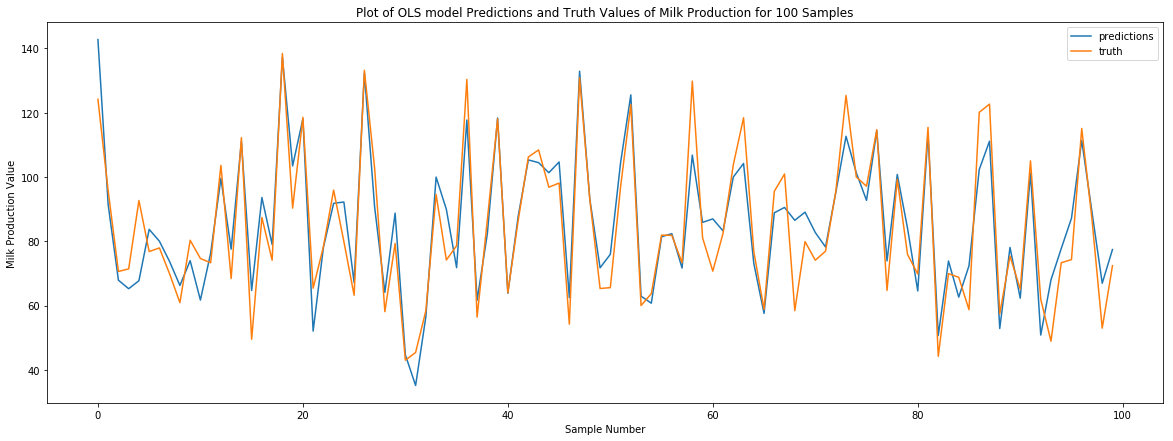

In [91]:
preds = lasso_preds["AvgMilk"]
_, _, _, actual = target_splits["AvgMilk"]

plt.figure(figsize=(20,7))
plt.plot(range(100), lasso_preds["AvgMilk"][:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of OLS model Predictions and Truth Values of Milk Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Milk Production Value");

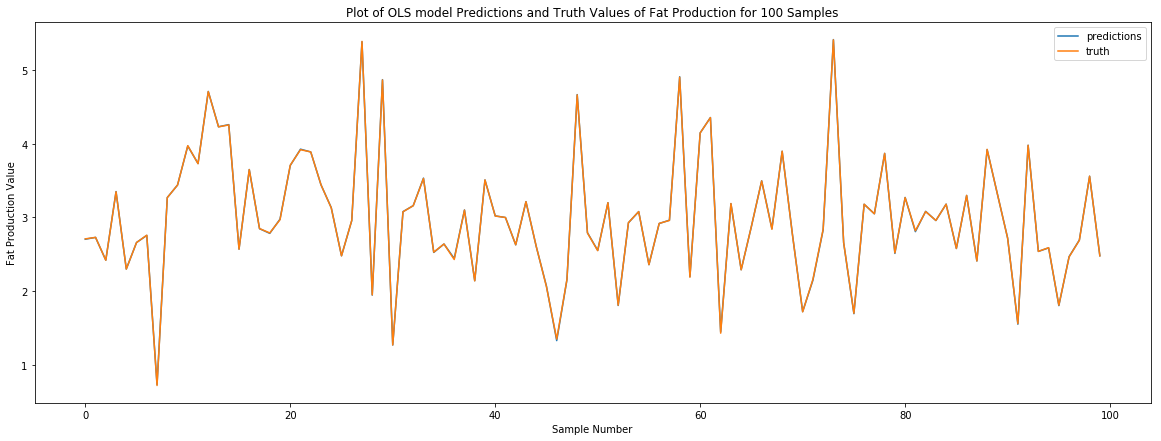

In [92]:
preds = lasso_preds["FatY"]
_, _, _, actual = target_splits["FatY"]

plt.figure(figsize=(20,7))
plt.plot(range(100), lasso_preds["FatY"][:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of OLS model Predictions and Truth Values of Fat Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Fat Production Value");

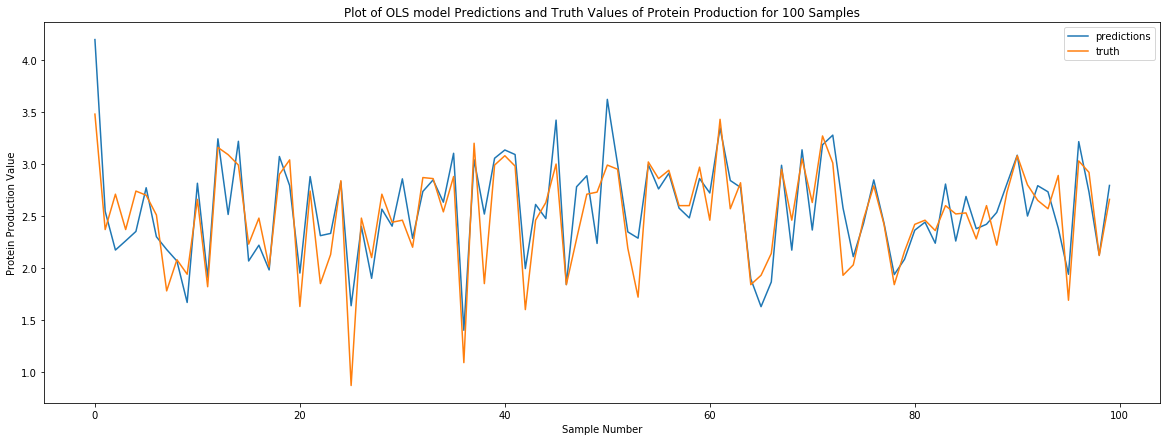

In [93]:
preds = lasso_preds["ProY"]
_, _, _, actual = target_splits["ProY"]

plt.figure(figsize=(20,7))
plt.plot(range(100), lasso_preds["ProY"][:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of OLS model Predictions and Truth Values of Protein Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Protein Production Value");

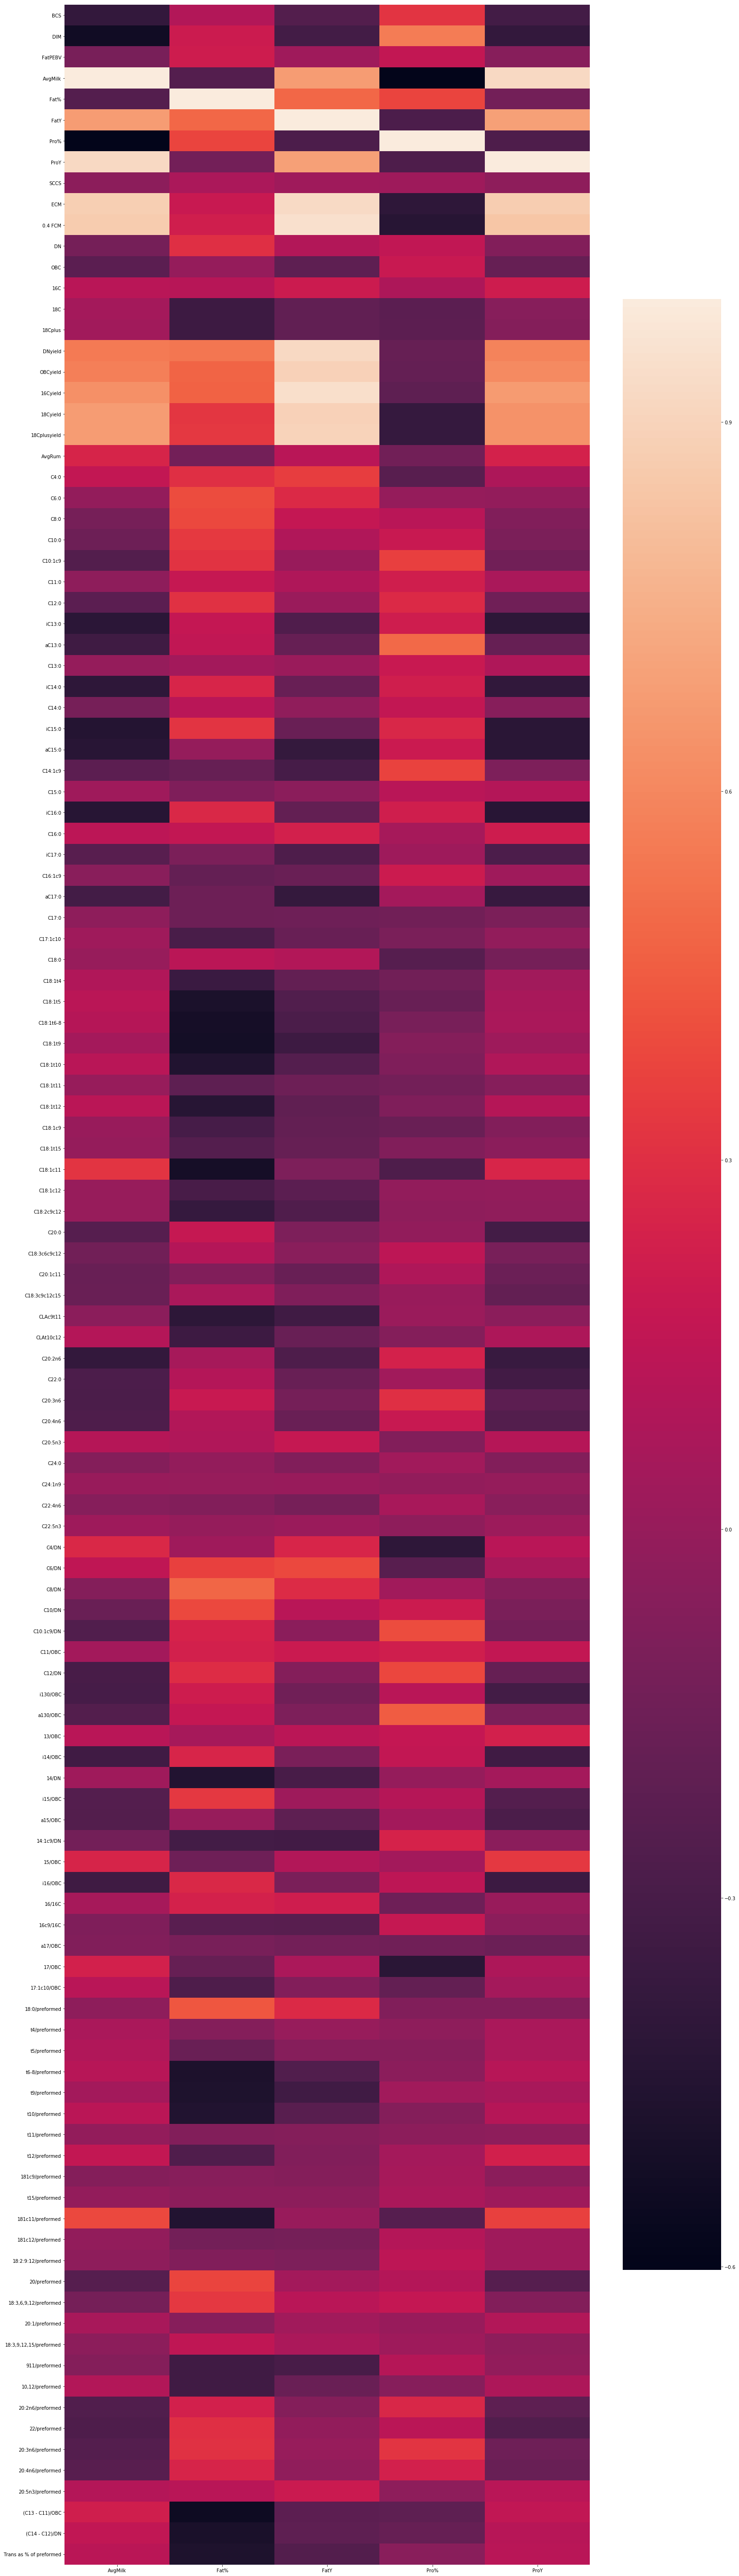

In [96]:
plt.figure(figsize = (25,100))
sns.heatmap(filtered_data.corr().loc[:,targets])

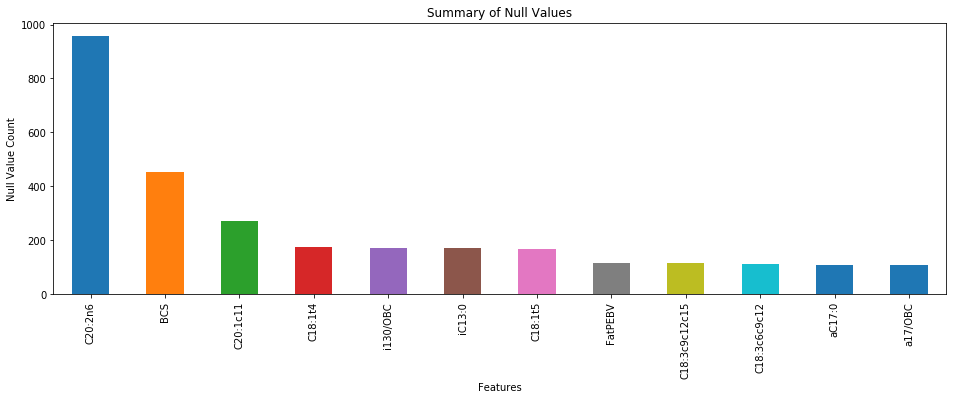

In [97]:
plt.figure(figsize=(16, 5))
plt.title("Summary of Null Values")
plt.xlabel("Features")
plt.ylabel("Null Value Count");
null_summary.iloc[:12].plot.bar()